# B08705012 胡家愷 HW4

In [15]:
# load packages
%matplotlib inline
import pickle
from sklearn import preprocessing

# Load data
with open('msd_full.pickle', 'rb') as fh1:
    msd_data = pickle.load(fh1)

doscaling = 1
if (doscaling == 1):
    xscaler = preprocessing.StandardScaler().fit(msd_data['X_train'])
    # standardize feature values
    X_train = xscaler.transform(msd_data['X_train'])
    X_test = xscaler.transform(msd_data['X_test'])
else:
    X_train = msd_data['X_train']
    X_test = msd_data['X_test']

Y_train = msd_data['Y_train']
Y_test = msd_data['Y_test'].astype('float32')
X_test = X_test.astype('float32')

y_mean = Y_train.mean()
Y_train_keep = Y_train.copy()
Y_test_keep = Y_test.copy()
Y_train = Y_train - y_mean
Y_test = Y_test - y_mean


# validation is the last 10% of training, subtraining is the first 90% of training
nvalid = int(X_train.shape[0] * 0.1)
nsubtrain = X_train.shape[0] - nvalid

X_subtrain = X_train[0:nsubtrain, :].astype('float32')
X_valid = X_train[nsubtrain:, :].astype('float32')
Y_subtrain = Y_train[0:nsubtrain].astype('float32')
Y_valid = Y_train[nsubtrain:].astype('float32')

Y_subtrain_keep = Y_train_keep[0:nsubtrain].astype('float32')
Y_valid_keep = Y_train_keep[nsubtrain:].astype('float32')

print("X_train shape = ", X_train.shape)
print("X_subtrain shape = ", X_subtrain.shape)
print("X_valid shape = ", X_valid.shape)
print("Y_subtrain shape = ", Y_subtrain.shape)
print("Y_valid shape = ", Y_valid.shape)
print("X_test shape = ", X_test.shape)

X_train shape =  (463715, 90)
X_subtrain shape =  (417344, 90)
X_valid shape =  (46371, 90)
Y_subtrain shape =  (417344,)
Y_valid shape =  (46371,)
X_test shape =  (51630, 90)


In [16]:
import torch
print(torch.cuda.is_available())

True


## Q1
使用Training資料訓練一個Ordinary Least Square模型，並進行預測。列出此模型的RMSE與前五個特徵的參數。OLS模型應包含常數項，且不應有任何Regularization。

In [17]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

reg = LinearRegression(n_jobs=-1)
reg.fit(X_subtrain, Y_subtrain_keep)
print("First 5 coefficients:", reg.coef_[0:5])
y_pred = reg.predict(X_test)


# squared: bool, default=True
# If True returns MSE value, if False returns RMSE value.
print("RMSE = ", mean_squared_error(Y_test_keep, y_pred, squared=False))

First 5 coefficients: [ 5.2934256  -2.8868346  -1.5276458   0.06307244 -0.33957964]
RMSE =  9.509892


## Q2

- 建構一個有四層Hidden Layer的MLP。
- 此模型由輸入層開始，90個Input Features通過線性層轉換為H個Hidden Nodes，
- 通過ReLu Activation Function，此為第一層Hidden Layer。
- 接著通過下一個線性層與ReLu Activation Function，此為第二層。
- 接著下一個線性層與ReLu Activation Function，此為第三層。 
- 然後下一個線性層與ReLu Activation Function，此為第四層。
- 最後通過一個線性層輸出。 所有Hidden Layer的寬度都為H。

令 H= 45, 使用 SGD 更新參數，設 Learning Rate = 0.00001，無 Weight Decay 與 Momentum。畫出模型訓練過程中的 Training 與Validation RMSE，列出 Test RMSE。
並討論訓練過程中 Training 與 Validation RMSE 的圖形意義。

In [18]:
import torch
from torch.utils import data

class Dataset(data.Dataset):
  def __init__(self, X, Y):
        self.labels = Y
        self.len = X.shape[0]
        self.X = X
        self.Y = Y
        

  def __len__(self):
        return self.len

  def __getitem__(self, index):
        X = self.X[index]
        y = self.Y[index]
        return X, y

### Create Dataloader

In [19]:
trainset = Dataset(X_train, Y_train)
subtrainset = Dataset(X_subtrain, Y_subtrain)
validset = Dataset(X_valid, Y_valid)
testset = Dataset(X_test, Y_test)

trainloader = data.DataLoader(trainset, batch_size=1000, shuffle=True, num_workers=0)
subtrainloader = data.DataLoader(subtrainset, batch_size=1000, shuffle=True, num_workers=0)
validloader = data.DataLoader(validset, batch_size=10000, shuffle=True, num_workers=0)
testloader = data.DataLoader(testset, batch_size=10000, shuffle=True, num_workers=0)

### Create Model

- Minibatch: 1,000個資料點，更新參數之後稱為經歷了一個Batch。
- 當所有 Subtraining 資料已經用來更新過模型參數，稱為經過了一個Epoch。
- 每 100 個 Batch 計算一次 Training and Validation RMSE。
- 如果 Validation 為歷史最低，則記下當下的模型參數與當時已進行的 Batch 數量，稱為best_step_count。
- early_stop 設為 5,000 個 Batch。

In [24]:
import numpy as np

def train(net, optimizer, loss_func, trainloader, validloader, epochs=100, patient=5000, model_path='model/result.ckpt', verbose=True):
    '''
    ### Parameters
    - net: model
    - optimizer: optimizer (Adam or SGD)
    - loss_func: loss function
    - trainloader: training data loader
    - validloader: validation data loader
    - epochs: number of epochs
    - patient: number of batches to wait before early stopping
    - verbose: print training progress
    - model_path: path to save model
    '''
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    step_count = 0
    best_step_count = 0
    interval = 100

    train_loss_list = []
    valid_loss_list = []
    best_valid_rmse = float("inf")

    best_net_state = {}
    stop = False

    for epoch in range(epochs):
        if stop:
            break
        for _, (data, target) in enumerate(trainloader):
            step_count += 1
            net.train()
            target = target.reshape((-1, 1))
            data = data.to(device)
            target = target.to(device)

            optimizer.zero_grad()
            output = net(data)
            
            loss = loss_func(output, target)
            loss.backward()
            optimizer.step()

            # 每 100 個 Batch 計算一次 Training and Validation RMSE
            if step_count % interval == 0:
                net.eval() # change to evaluation mode
                # calculate training loss with current model
                train_loss = 0
                for _, (data, target) in enumerate(trainloader):
                    target = target.reshape((-1, 1))
                    data = data.to(device)
                    target = target.to(device)
                    output = net(data)
                    train_loss += torch.nn.MSELoss(reduction='sum')(output, target).item()
                    
                train_rmse = np.sqrt(train_loss / len(trainloader.dataset))
                train_loss_list.append(train_rmse)      
                
                # calculate validation loss with current model
                valid_loss = 0   
                for _, (data, target) in enumerate(validloader):
                    target = target.reshape((-1, 1))
                    data = data.to(device)
                    target = target.to(device)
                    output = net(data)
                    valid_loss += torch.nn.MSELoss(reduction='sum')(output, target).item()
                
                valid_rmse = np.sqrt(valid_loss / len(validloader.dataset))
                valid_loss_list.append(valid_rmse)

                if verbose:
                    print(f'[Epoch {epoch+1:3}] | Step {step_count:5} | Train RMSE {train_rmse:7.5f} | Valid RMSE {valid_rmse:7.5f}')
                
                # if current valid rmse < history best valid rmse, store current model to be the best model
                if valid_rmse < best_valid_rmse:
                    best_valid_rmse = valid_rmse
                    best_step_count = step_count
                    best_net_state = net.state_dict()
                    torch.save(net, model_path)
                elif step_count - best_step_count > patient:
                    print("Early stopping at epoch", epoch+1)
                    stop = True
                    break
    return net, best_net_state, train_loss_list, valid_loss_list

In [25]:
def mlp_model(input_size, hidden_size, output_size):
    model = torch.nn.Sequential(
        torch.nn.Linear(input_size, hidden_size),
        torch.nn.ReLU(),
        torch.nn.Linear(hidden_size, hidden_size),
        torch.nn.ReLU(),
        torch.nn.Linear(hidden_size, hidden_size),
        torch.nn.ReLU(),
        torch.nn.Linear(hidden_size, hidden_size),
        torch.nn.ReLU(),
        torch.nn.Linear(hidden_size, output_size)
    )
    return model

net = mlp_model(trainset.X.shape[1], 45, 1)

In [26]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = net.float()
net = net.to(device)

optimizer = torch.optim.SGD(net.parameters(), lr=0.00001, momentum=0, weight_decay=0)
loss_func = torch.nn.MSELoss(reduction='sum')

In [27]:
model, best_net_state, train_loss_list, valid_loss_list = train(net, optimizer=optimizer, loss_func=loss_func, trainloader=subtrainloader, validloader=validloader, epochs=100, model_path="model/q2.ckpt")

[Epoch   1] | Step   100 | Train RMSE 10.68697 | Valid RMSE 10.65940
[Epoch   1] | Step   200 | Train RMSE 9.06249 | Valid RMSE 8.99830
[Epoch   1] | Step   300 | Train RMSE 8.93918 | Valid RMSE 8.89137
[Epoch   1] | Step   400 | Train RMSE 8.94253 | Valid RMSE 8.89147
[Epoch   2] | Step   500 | Train RMSE 8.93823 | Valid RMSE 8.90315
[Epoch   2] | Step   600 | Train RMSE 8.88845 | Valid RMSE 8.85021
[Epoch   2] | Step   700 | Train RMSE 8.75880 | Valid RMSE 8.72612
[Epoch   2] | Step   800 | Train RMSE 8.81743 | Valid RMSE 8.80549
[Epoch   3] | Step   900 | Train RMSE 8.72337 | Valid RMSE 8.71285
[Epoch   3] | Step  1000 | Train RMSE 8.69646 | Valid RMSE 8.69873
[Epoch   3] | Step  1100 | Train RMSE 8.67294 | Valid RMSE 8.67442
[Epoch   3] | Step  1200 | Train RMSE 8.70391 | Valid RMSE 8.71300
[Epoch   4] | Step  1300 | Train RMSE 8.66576 | Valid RMSE 8.67803
[Epoch   4] | Step  1400 | Train RMSE 8.67534 | Valid RMSE 8.69485
[Epoch   4] | Step  1500 | Train RMSE 8.63137 | Valid RMSE 8

[Text(0.5, 0, 'number of batches'), Text(0, 0.5, 'RMSE')]

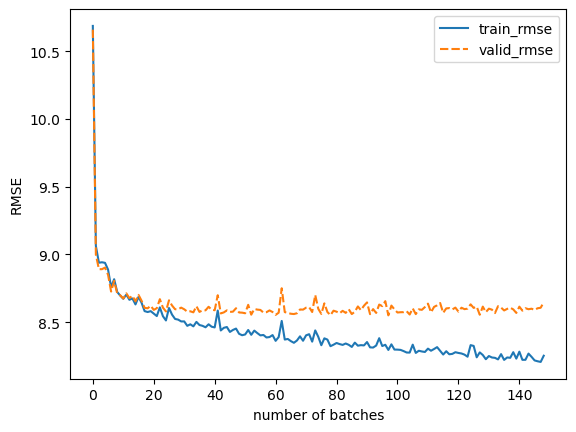

In [28]:
import seaborn as sns
import pandas as pd

df_loss = pd.DataFrame({"train_rmse": train_loss_list, "valid_rmse": valid_loss_list})

ax = sns.lineplot(data=df_loss, )
ax.set(xlabel='number of batches', ylabel='RMSE')

In [29]:
def test(net, testloader):
    net.eval()
    test_loss = 0
    test_loss_cnt = 0
    for _, (data, target) in enumerate(testloader):
        target = target.reshape((-1, 1))
        data = data.to(device)
        target = target.to(device)
        output = net(data)
        loss = loss_func(output, target)
        test_loss += loss.item()
        test_loss_cnt += data.shape[0]
    test_rmse = np.sqrt(test_loss / test_loss_cnt)
    print("Test RMSE: ", test_rmse)    

In [34]:
model = torch.load('model/q2.ckpt')
test(model, testloader)

Test RMSE:  8.904900716625187


我們可以發現 validation 的 rmse 在大概 15 個 batch 之後就會穩定在 training 的 rmse 上方，這是預期且合理的，我們接著可以發現 validation 大概到 40 個 batch 之後就趨於穩定，rmse 不沒有再繼續減少，但 training rmse 持續減少，這時候代表可能開始出現 overfitting 的現象，但模型在 epoch 36 就及時做出 early stopping，避免 overfitting 太嚴重。

## Q3
使用H = 90與180。無須畫訓練過程的RMSE。列出這兩個Test RMSE。討論H = 45, 90, 180的Test RMSE。

### H=90

In [35]:
net = mlp_model(trainset.X.shape[1], 90, 1)
net = net.to(device)
optimizer = torch.optim.SGD(net.parameters(), lr=0.00001, momentum=0, weight_decay=0)
model, best_net_state, _, _ = train(net, optimizer=optimizer, loss_func=loss_func, trainloader=subtrainloader, validloader=validloader, epochs=100, verbose=False, model_path="model/q3_90.ckpt")

Early stopping at epoch 23


In [36]:
model = torch.load('model/q3_90.ckpt')
test(model, testloader)

Test RMSE:  8.80093818800341


### H=180

In [37]:
net = mlp_model(trainset.X.shape[1], 180, 1)
net = net.to(device)
optimizer = torch.optim.SGD(net.parameters(), lr=0.00001, momentum=0, weight_decay=0)
model, best_net_state, _, _ = train(net, optimizer=optimizer, loss_func=loss_func, trainloader=subtrainloader, validloader=validloader, epochs=100, verbose=False, model_path="model/q3_180.ckpt")

Early stopping at epoch 23


In [38]:
model = torch.load('model/q3_180.ckpt')
test(model, testloader)

Test RMSE:  8.841749610276855


H = 45, 90, 180 分別的 Test RMSE 是 8.9049, 8.8009, 8.8417，代表當 H=90 時，RMSE 最小，因此在本題中，選擇 H=90 會是比較好的選擇。

## Q4
使用Q2的模型設定，考慮 H = 45, 90, 180與Weight Decay = 0.1, 0.2, 0.4的所有組合。模型估計後做表整理Test RMSE。討論H的選擇應為多少較合理?

In [41]:
H_list = [45, 90, 180]
weight_decay_list = [0.1, 0.2, 0.4]

for h in H_list:
    for weight_decay in weight_decay_list:
        print("H:", h, "weight_decay:", weight_decay)
        net = mlp_model(trainset.X.shape[1], h, 1)
        net = net.float().to(device)
        optimizer = torch.optim.SGD(net.parameters(), lr=0.00001, momentum=0, weight_decay=weight_decay)
        model, best_net_state, _, _ = train(net, optimizer=optimizer, loss_func=loss_func, trainloader=subtrainloader, validloader=validloader, epochs=100, verbose=False, model_path=f"model/q4_{h}_{weight_decay}.ckpt")
        model = torch.load(f"model/q4_{h}_{weight_decay}.ckpt")
        test(model, testloader)
        print("\n")

H: 45 weight_decay: 0.1
Early stopping at epoch 36
Test RMSE:  8.822548017726076


H: 45 weight_decay: 0.2
Early stopping at epoch 37
Test RMSE:  8.868997596473907


H: 45 weight_decay: 0.4
Early stopping at epoch 26
Test RMSE:  8.81216097457302


H: 90 weight_decay: 0.1
Early stopping at epoch 26
Test RMSE:  8.8434977107545


H: 90 weight_decay: 0.2
Early stopping at epoch 28
Test RMSE:  8.846006188617366


H: 90 weight_decay: 0.4
Early stopping at epoch 23
Test RMSE:  8.838997279430052


H: 180 weight_decay: 0.1
Early stopping at epoch 24
Test RMSE:  8.897579257441652


H: 180 weight_decay: 0.2
Early stopping at epoch 20
Test RMSE:  8.793388996750874


H: 180 weight_decay: 0.4
Early stopping at epoch 20
Test RMSE:  8.829385976710999




| H\Weight Decay | 0.1    | 0.2    | 0.4    |
|----------------|--------|--------|--------|
| 45             | 8.8225 | 8.8690 | 9.8122 |
| 90             | 8.8435 | 8.8460 | 8.8390 |
| 180            | 8.8976 | 8.7934 | 8.8294 |

可以發現，當 weight dacay = 0.2 或 0.4 時，H 愈大， RMSE 愈小，當 weight decay = 0.1 時，H 愈小愈好。

在本題中，H = 45, weight decay = 0.1，有最小的 RMSE，為最佳結果。

## Q5
建構一個有Dropout的四層Hidden Layer的MLP。
- 第一層由90個Input Features通過線性層轉換為H個Hidden Nodes
- 通過ReLu Activation Function
- 對Hidden Unit Dropout，機率為0.5。
- 後面各Hidden Lyaer均在ReLu後有Dropout，機率皆為0.5。
- 最後通過一個線性層輸出。所有Hidden Layer的寬度都為H。

- 令 H= 90, 使用Adaptive Moment Estimation (Adam)更新參數
- 設Learning Rate = 0.001，無Weight Decay與Momentum。
- 畫出模型訓練過程中的Training與Validation RMSE，列出Test RMSE。 並討論訓練過程中Training與Validation RMSE的圖形意義。

In [42]:
def mlp_model_with_dropout(input_size, H, output_size, dropout_rate):
    model = torch.nn.Sequential(
        torch.nn.Linear(input_size, H),
        torch.nn.ReLU(),
        torch.nn.Dropout(dropout_rate),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(),
        torch.nn.Dropout(dropout_rate),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(),
        torch.nn.Dropout(dropout_rate),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(),
        torch.nn.Dropout(dropout_rate),
        torch.nn.Linear(H, output_size)
    )
    return model

In [45]:
net = mlp_model_with_dropout(trainset.X.shape[1], 90, 1, 0.5)
net = net.float().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay=0)
loss_func = torch.nn.MSELoss(reduction='sum')

In [46]:
model, best_net_state, train_loss_list, valid_loss_list = train(net, optimizer=optimizer, loss_func=loss_func, trainloader=subtrainloader, validloader=validloader, epochs=100, model_path="model/q5_90.ckpt")

[Epoch   1] | Step   100 | Train RMSE 9.46201 | Valid RMSE 9.42325
[Epoch   1] | Step   200 | Train RMSE 9.15519 | Valid RMSE 9.09959
[Epoch   1] | Step   300 | Train RMSE 9.06805 | Valid RMSE 9.01577
[Epoch   1] | Step   400 | Train RMSE 9.00191 | Valid RMSE 8.94882
[Epoch   2] | Step   500 | Train RMSE 8.94912 | Valid RMSE 8.89655
[Epoch   2] | Step   600 | Train RMSE 8.93622 | Valid RMSE 8.89115
[Epoch   2] | Step   700 | Train RMSE 8.88564 | Valid RMSE 8.83631
[Epoch   2] | Step   800 | Train RMSE 8.87181 | Valid RMSE 8.82155
[Epoch   3] | Step   900 | Train RMSE 8.85925 | Valid RMSE 8.81549
[Epoch   3] | Step  1000 | Train RMSE 8.82194 | Valid RMSE 8.78020
[Epoch   3] | Step  1100 | Train RMSE 8.84195 | Valid RMSE 8.79773
[Epoch   3] | Step  1200 | Train RMSE 8.80585 | Valid RMSE 8.75818
[Epoch   4] | Step  1300 | Train RMSE 8.79161 | Valid RMSE 8.75252
[Epoch   4] | Step  1400 | Train RMSE 8.77818 | Valid RMSE 8.74462
[Epoch   4] | Step  1500 | Train RMSE 8.76661 | Valid RMSE 8.7

[Text(0.5, 0, 'number of batches'), Text(0, 0.5, 'RMSE')]

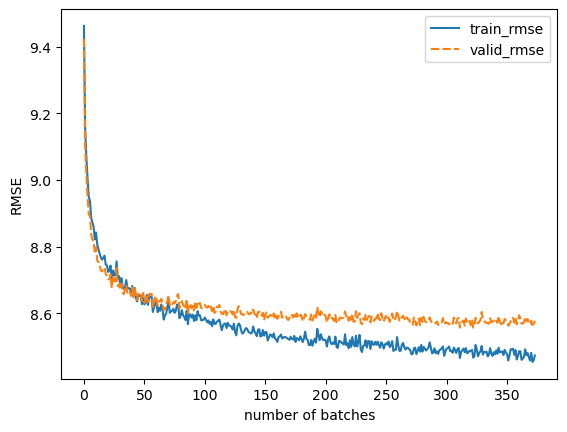

In [47]:
df_loss = pd.DataFrame({"train_rmse": train_loss_list, "valid_rmse": valid_loss_list})

ax = sns.lineplot(data=df_loss, )
ax.set(xlabel='number of batches', ylabel='RMSE')

In [48]:
model = torch.load("model/q5_90.ckpt")
test(model, testloader)

Test RMSE:  8.763391092610185


可以看到沒有使用 dropout 且用 SGD 的模型來說，使用 dropout 搭配 Adam 會訓練得更久，到 epoch 90 才停下來。

也可以看到 validation RMSE 到 batch 200 之前都呈現持續下降的趨勢，顯示 dropout 搭配 Adam 的這組模型確實能夠有效避免 overfitting。

## Q6
使用上題的模型，考慮H = 20, 180, 360。 討論H = 20, 45, 180, 360的Test RMSE。

### H = 20

In [49]:
net = mlp_model_with_dropout(trainset.X.shape[1], 20, 1, 0.5)
net = net.float().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay=0)
model, best_net_state, _, _ = train(net, optimizer=optimizer, loss_func=loss_func, trainloader=subtrainloader, validloader=validloader, epochs=100, verbose=False, model_path="model/q6_20.ckpt")

Early stopping at epoch 46


In [50]:
model = torch.load("model/q6_20.ckpt")
test(model, testloader)

Test RMSE:  9.06878153437954


### H = 45

In [51]:
net = mlp_model_with_dropout(trainset.X.shape[1], 45, 1, 0.5)
net = net.float().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay=0)
model, best_net_state, _, _ = train(net, optimizer=optimizer, loss_func=loss_func, trainloader=subtrainloader, validloader=validloader, epochs=100, verbose=False, model_path="model/q6_45.ckpt")

Early stopping at epoch 58


In [52]:
model = torch.load("model/q6_45.ckpt")
test(model, testloader)

Test RMSE:  8.847487622828474


### H = 180

In [53]:
net = mlp_model_with_dropout(trainset.X.shape[1], 180, 1, 0.5)
net = net.float().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001,  weight_decay=0)
model, best_net_state, _, _ = train(net, optimizer=optimizer, loss_func=loss_func, trainloader=subtrainloader, validloader=validloader, epochs=100, verbose=False, model_path="model/q6_180.ckpt")

In [54]:
model = torch.load("model/q6_180.ckpt")
test(model, testloader)

Test RMSE:  8.765667643256595


### H = 360

In [55]:
net = mlp_model_with_dropout(trainset.X.shape[1], 360, 1, 0.5)
net = net.float().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001,  weight_decay=0)
model, best_net_state, _, _ = train(net, optimizer=optimizer, loss_func=loss_func, trainloader=subtrainloader, validloader=validloader, epochs=100, verbose=False, model_path="model/q6_360.ckpt")

Early stopping at epoch 72


In [56]:
model = torch.load("model/q6_360.ckpt")
test(model, testloader)

Test RMSE:  8.74037183677281


| H   | RMSE   |
|-----|--------|
| 20  | 9.0688 |
| 45  | 8.8475 |
| 90  | 8.7634 |
| 180 | 8.7657 |
| 360 | 8.7404 |

針對有 dropout 且使用 Adam 的模型，我們可以發現大致上 H 愈大，RMSE 愈小，當 H=360 時，有最小的 RMSE=8.7404。

## Q7

我們前面的小題皆是使用SSE，也就是L2 Loss。一個改善模型訓練的方式是使用多種類似的Loss，以線性組合的方式建構Loss Function。請使用Q5中的MLP with Dropout模型 (H = 90)，並以L2 + L1 Loss訓練模型。這個Loss的定義如下:

$$
loss(\mathbf{y}, \hat{\mathbf{y}}) = z \sum_{i=1}^n (y_i - \hat{y}_i)^2 + (1 - z) \sum_{i = 1}^n | y_i - \hat{y}_i |,
$$
其中z為實數且$0 <=z <= 1$。

使用z = 0.5。並以Adam訓練模型。畫出Training and Validation RMSE，並報告Test RMSE。注意這裡繪圖時應使用RMSE而不是這個特殊的Loss。

另外，使用z = 0.0, 0.1, 0.9, 1.0訓練模型(不須提供訓練過程的Loss圖形)，統整各個z值下的Test RMSE並討論。

In [57]:
def l2l1_loss_func(outputs, targets, z=0.5):
    return z * torch.nn.MSELoss(reduction='sum')(outputs, targets) + (1-z) * torch.nn.L1Loss(reduction = 'sum')(outputs, targets)

In [59]:
net = mlp_model_with_dropout(trainset.X.shape[1], 90, 1, 0.5)
net = net.float().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay=0)
model, best_net_state, train_loss_list, valid_loss_list = train(net, optimizer=optimizer, loss_func=l2l1_loss_func, trainloader=subtrainloader, validloader=validloader, epochs=100, verbose=False, model_path="model/q7_0.5.ckpt")

[Text(0.5, 0, 'number of batches'), Text(0, 0.5, 'RMSE')]

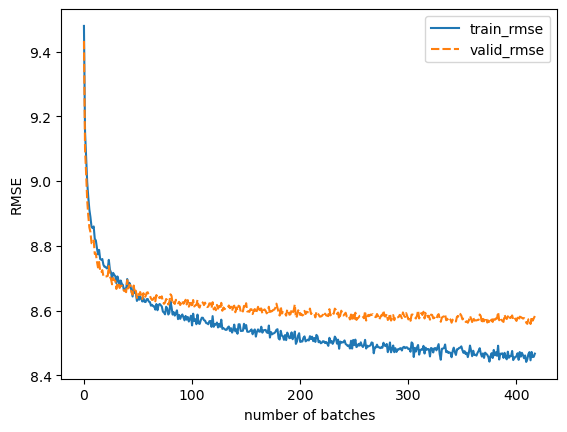

In [60]:
df_loss = pd.DataFrame({"train_rmse": train_loss_list, "valid_rmse": valid_loss_list})

ax = sns.lineplot(data=df_loss, )
ax.set(xlabel='number of batches', ylabel='RMSE')

In [61]:
model = torch.load("model/q7_0.5.ckpt")
test(model, testloader)

Test RMSE:  8.76065427621565


在本題中，我們可以看到調整過後的 loss function 帶來更好的結果，validation RMSE 一直到 epoch 100 都持續呈現下降趨勢。

In [62]:
z_list= [0.0, 0.1, 0.9, 1.0]

for z in z_list:
    print("z = ", z)
    net = mlp_model_with_dropout(trainset.X.shape[1], 90, 1, 0.5)
    net = net.float().to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay=0)
    def l2l1_loss_func(outputs, targets, z=z):
        return z * torch.nn.MSELoss(reduction='sum')(outputs, targets) + (1-z) * torch.nn.L1Loss(reduction = 'sum')(outputs, targets)
    model, best_net_state, _, _ = train(net, optimizer=optimizer, loss_func=l2l1_loss_func, trainloader=subtrainloader, validloader=validloader, epochs=100, verbose=False, model_path=f"model/q7_{z}.ckpt")
    model = torch.load(f"model/q7_{z}.ckpt")
    test(model, testloader)
    print()

z =  0.0
Early stopping at epoch 47
Test RMSE:  8.97248520992324

z =  0.1
Early stopping at epoch 85
Test RMSE:  8.75208426969091

z =  0.9
Early stopping at epoch 62
Test RMSE:  8.75953474930647

z =  1.0
Early stopping at epoch 98
Test RMSE:  8.763557932957136



| z   | RMSE   |
|-----|--------|
| 0   | 8.9725 |
| 0.1 | 8.7521 |
| 0.5 | 8.7607 |
| 0.9 | 8.7595 |
| 1.0 | 8.7636 |

可以看到當 $z \neq 0$ 時，都比 $ z = 0 $ 有比較好的表現，其中當 $z=0.1$ 時，有最好的表現。

#### Q8 
考慮另一個比較特別的Loss Function

$$
qloss(\mathbf{y}, \hat{\mathbf{y}}) = \sum_{i=1}^n \{ q (y_i - \hat{y}_i)_+ + (1 - q) (\hat{y}_i - y_i)_+ \},
$$
其中q為參數且$0<=q<=1$，而$(y_i - \hat{y}_i)_+$是取正值的意思。也就是說如果$(y_i - \hat{y}_i) > 0$，則$(y_i - \hat{y}_i)_+ = y_i - \hat{y}_i$，否則$(y_i - \hat{y}_i)_+ = 0$。

令模型的Loss為$z \sum_{i=1}^n (y_i - \hat{y}_i)^2 + (1 - z) \sum_{i=1}^n \{ 0.5 (y_i - \hat{y}_i)_+ + 0.5 (\hat{y}_i - y_i)_+ \} $。請使用Q5中的MLP with Dropout模型(H = 90)，令z = 0。並以Adam訓練模型。畫出Training and Validation RMSE，並報告Test RMSE。注意這裡繪圖時應使用RMSE而不是這個特殊的Loss。

另外，使用z = 0.1, 0.5, 0.9, 1.0訓練模型(不須提供訓練過程的Loss圖形)，統整各個z值下的Test RMSE並討論。

In [63]:
def qloss(outputs, targets, q=0.5):
    temp = targets - outputs
    loss = torch.max(q*temp, (1-q)*(-temp))
    return loss.sum()

def special_loss_func(outputs, targets, z=0, q=0.5):
    return z * torch.nn.MSELoss(reduction='sum')(outputs, targets) + (1-z) * qloss(outputs, targets, q=q)

In [64]:
net = mlp_model_with_dropout(trainset.X.shape[1], 90, 1, 0.5)
net = net.float().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay=0)
model, best_net_state, train_loss_list, valid_loss_list = train(net, optimizer=optimizer, loss_func=special_loss_func, trainloader=subtrainloader, validloader=validloader, epochs=100, verbose=False, model_path="model/q8_0.ckpt")

Early stopping at epoch 43


[Text(0.5, 0, 'number of batches'), Text(0, 0.5, 'RMSE')]

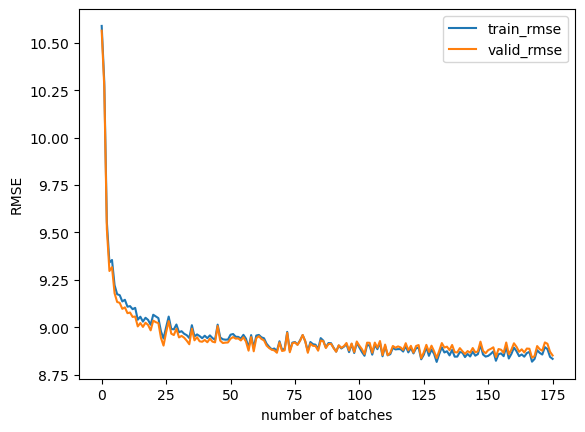

In [68]:
df_loss = pd.DataFrame({"train_rmse": train_loss_list, "valid_rmse": valid_loss_list})

ax = sns.lineplot(data=df_loss, dashes=False)
ax.set(xlabel='number of batches', ylabel='RMSE')

In [66]:
model = torch.load("model/q8_0.ckpt")
test(model, testloader)

Test RMSE:  8.936323391111841


可以看到採用這個 loss 計算方式之後，validation 以及 training 的 RMSE 呈現幾乎重疊的狀態，代表沒有發生 overfitting 的現象，但缺點就是 Test RMSE 相對其他模型來說比較高一點。

In [67]:
z_list= [0.1, 0.5, 0.9, 1.0]

for z in z_list:
    print("z = ", z)
    net = mlp_model_with_dropout(trainset.X.shape[1], 90, 1, 0.5)
    net = net.float().to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay=0)
    def special_loss_func(outputs, targets, z=z, q=0.5):
        return z * torch.nn.MSELoss(reduction='sum')(outputs, targets) + (1-z) * qloss(outputs, targets, q=q)
    model, best_net_state, _, _ = train(net, optimizer=optimizer, loss_func=special_loss_func, trainloader=subtrainloader, validloader=validloader, epochs=100, verbose=False, model_path=f"model/q8_{z}.ckpt")
    model = torch.load(f"model/q8_{z}.ckpt")
    test(model, testloader)
    print()

z =  0.1
Early stopping at epoch 69
Test RMSE:  8.773000607384914

z =  0.5
Test RMSE:  8.761629081902841

z =  0.9
Early stopping at epoch 73
Test RMSE:  8.762371497412527

z =  1.0
Early stopping at epoch 80
Test RMSE:  8.762033140099872



| z   | RMSE   |
|-----|--------|
| 0   | 8.9363 |
| 0.1 | 8.7730 |
| 0.5 | 8.7616 |
| 0.9 | 8.7624 |
| 1.0 | 8.7620 |

由上表可知，當 z = 0.5, 0.9, 1.0 時，模型都有不錯的表現，但與前一題 L2+L1 Loss 相比，表現稍微比較差一點，本題中，最好的 z 值應設在 0.5，Test RMSE 為 8.7616。